## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Setting up the necessary paths

In [2]:
import os
root_dir = "F:/"
project_folder = "sparktech/"
os.chdir(root_dir+project_folder)

# Print the current directory
print("Current directory:", os.getcwd())

plt.ion()

Current directory: F:\sparktech


## Setting up the dataset

In [3]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = root_dir + project_folder + 'dataset'
os.chdir(data_dir)

#Print the current directory
print("Current directory:", os.getcwd())

Current directory: F:\sparktech\dataset


## Setting up the dataframe and removing null values

In [4]:
train_db = pd.read_csv(root_dir + project_folder + 'dataset/train.csv', encoding='latin1', on_bad_lines='skip')
data_filled = train_db.fillna('unknown')
train_df = pd.DataFrame(data_filled)
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
# Remove rows with any remaining missing values
train_df = train_df.dropna()

In [ ]:
# Drop unnecessary columns
columns_to_drop = ['id', 'qid1', 'qid2']
train_df = train_df.drop(columns=columns_to_drop)


In [7]:
# Display the first few rows of the cleaned DataFrame
train_df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
# Show the shape of the cleaned DataFrame
train_df.shape

(404347, 3)

In [10]:
# Display information about the cleaned DataFrame
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404347 entries, 0 to 404346
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   question1     404347 non-null  object
 1   question2     404347 non-null  object
 2   is_duplicate  404347 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.3+ MB


In [11]:
# Display the distribution of the target variable
train_df['is_duplicate'].value_counts()

is_duplicate
0    255042
1    149305
Name: count, dtype: int64

In [12]:
# Display the column names of the cleaned DataFrame
print(train_df.columns)

Index(['question1', 'question2', 'is_duplicate'], dtype='object')


## Text preprocessing starts from here

In [13]:
# Text Preprocessing Function
# This function preprocesses text data by removing HTML tags, expanding contractions,
# removing stopwords, stemming, and other cleaning steps.
def text_processing(data, text_col):
    from bs4 import BeautifulSoup
    import re
    from wordcloud import STOPWORDS
    from tqdm import tqdm
    from nltk.stem import PorterStemmer

    def decontracted(phrase):
        phrase = re.sub(r'<br /><br />',' ', phrase)
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r'"', " ", phrase)
        return phrase

    stopwords = set(STOPWORDS)
    porter = PorterStemmer()
    preprocessed_texts = []

    for sentence in tqdm(data[text_col].astype(str).values):
        sentence = re.sub(r"http\S+", "", sentence)  # remove URLs
        sentence = BeautifulSoup(sentence, 'lxml').get_text()  # remove HTML
        sentence = decontracted(sentence)  # expand contractions
        sentence = re.sub(r"\S*\d\S*", "", sentence).strip()  # remove numbers
        sentence = ' '.join(w.lower() for w in sentence.split() if w.lower() not in stopwords)  # lowercase + remove stopwords
        sentence = ' '.join(porter.stem(w) for w in sentence.split())  # stemming
        preprocessed_texts.append(sentence)

    return preprocessed_texts


In [14]:
# Checking the text_processing function
from nltk.stem import PorterStemmer
porter = PorterStemmer()
porter.stem('Going')

'go'

In [15]:
# Download necessary NLTK data files
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [16]:
# import these modules
# Lemmatization using WordNetLemmatizer
# 
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()


# 'pos' specifies the Part of Speech for accurate lemmatization.
# WordNet uses:
# n = noun, v = verb, a = adjective, r = adverb
# Providing the correct POS helps return the correct base form.
# Here, 'better' is an adjective, so pos='a' returns the lemma 'good'.

print("rocks :", lemmatizer.lemmatize("rocks"))
print("corpora :", lemmatizer.lemmatize("corpora"))
print("better :", lemmatizer.lemmatize("better", pos="a"))

rocks : rock
corpora : corpus
better : good


In [17]:
# Apply text processing to both question columns
q1_clean = text_processing(train_df, text_col='question1')
q2_clean = text_processing(train_df, text_col='question2')

  0%|          | 0/404347 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_1244\3046107764.py:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, 'lxml').get_text()  # remove HTML
  0%|          | 0/404347 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_1244\3046107764.py:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, 'lxml').get_text()  # remove HTML
100%|██████████| 404347/404347 [01:17<00:00, 5247.13it/s]


In [18]:
# Display some examples of the original and preprocessed questions
print("Original question1:", train_df['question1'].iloc[0]) # Display the first original question1
print("Preprocessed question1:", q1_clean[0])

print("Original question2:", train_df['question2'].iloc[5]) # Display the sixth original question2
print("Preprocessed question2:", q2_clean[5])


Original question1: What is the step by step guide to invest in share market in india?
Preprocessed question1: step step guid invest share market india?
Original question2: I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
Preprocessed question2: tripl capricorn (sun, moon ascend capricorn) say me?


In [ ]:
# Number of preprocessed items matches original
print(len(q1_clean), len(train_df))
print(len(q2_clean), len(train_df))

# Check first 5 rows
for i in range(5):
    print(f"Q1: {q1_clean[i]}") # Display the first 5 preprocessed question1
    print(f"Q2: {q2_clean[i]}") # Display the first 5 preprocessed question2
    print("-----")


404347 404347
404347 404347
Q1: step step guid invest share market india?
Q2: step step guid invest share market?
-----
Q1: stori kohinoor (koh-i-noor) diamond?
Q2: happen indian govern stole kohinoor (koh-i-noor) diamond back?
-----
Q1: increas speed internet connect use vpn?
Q2: internet speed increas hack dns?
-----
Q1: mental lonely? solv it?
Q2: find remaind divid
-----
Q1: one dissolv water quikli sugar, salt, methan carbon di oxide?
Q2: fish surviv salt water?
-----


In [ ]:
# Display the column names of the cleaned DataFrame
train_df.columns

Index(['question1', 'question2', 'is_duplicate'], dtype='object')

<Axes: xlabel='is_duplicate', ylabel='count'>

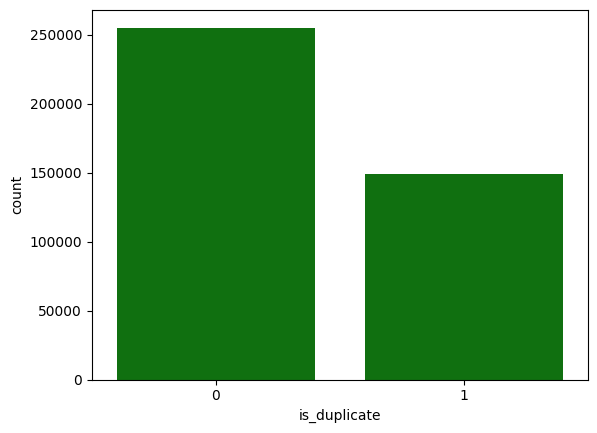

In [ ]:
# Display the distribution of the target variable using a count plot
sns.countplot(x='is_duplicate', data=train_df, color = 'green')

## Data spliting starts from here

In [ ]:
# Prepare data for model training
from sklearn.model_selection import train_test_split

# Combine the preprocessed questions into a single feature
X = [q1 + " " + q2 for q1, q2 in zip(q1_clean, q2_clean)]

# Target variable
y = train_df['is_duplicate'].values  # already 0/1

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% for testing
    random_state=42,    # for reproducibility
    stratify=y          # maintain class balance
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 323477
Testing samples: 80870


## Model training, Data Vectorization and saving starts form here


#### Logistic Regression model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Combine question pairs into single text
X_train_text = [' '.join(pair) if isinstance(pair, list) else pair for pair in X_train] 
X_test_text  = [' '.join(pair) if isinstance(pair, list) else pair for pair in X_test]

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf  = vectorizer.transform(X_test_text)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Evaluate
y_pred = lr_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save model & vectorizer
model_path = root_dir + project_folder + 'models/logistic_regression_model.pkl'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(lr_model, model_path)
joblib.dump(vectorizer, root_dir + project_folder + 'models/tfidf_vectorizer.pkl')
print("Logistic Regression model saved!")


Accuracy: 0.7509088660813652
              precision    recall  f1-score   support

           0       0.77      0.87      0.82     51009
           1       0.71      0.54      0.62     29861

    accuracy                           0.75     80870
   macro avg       0.74      0.71      0.72     80870
weighted avg       0.75      0.75      0.74     80870

Logistic Regression model saved!


## Univerisal model evalution function

In [83]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Universal evaluation function for binary classifiers.
    
    Works with:
    - Neural Networks (Keras/TensorFlow)
    - Scikit-learn models (SVM, Logistic Regression, RandomForest, etc.)
    
    Parameters:
    -----------
    model : trained model
    X_test : test features
    y_test : true labels
    threshold : float, default=0.5 (for neural networks)
    """
    # 1. Predict
    if hasattr(model, "predict_proba"):  # sklearn models with predict_proba
        y_scores = model.predict_proba(X_test)[:, 1]
        y_pred = (y_scores >= threshold).astype(int)
    elif hasattr(model, "decision_function"):  # SVM, etc.
        y_scores = model.decision_function(X_test)
        y_pred = (y_scores >= 0).astype(int)  # threshold=0 for decision_function
    else:  # Keras/TensorFlow models
        y_scores = model.predict(X_test).ravel()
        y_pred = (y_scores >= threshold).astype(int)

    # 2. Basic Metrics
    print("\nMODEL PERFORMANCE")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score : {f1_score(y_test, y_pred):.4f}")

    # 3. Classification Report
    print("\nCLASSIFICATION REPORT")
    print(classification_report(y_test, y_pred))

    # 4. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # 5. ROC-AUC Curve
    try:
        auc = roc_auc_score(y_test, y_scores)
        print(f"\nROC-AUC Score: {auc:.4f}")
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
        plt.plot([0,1],[0,1], linestyle="--")
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()
    except Exception as e:
        print("\nROC-AUC cannot be computed:", e)



MODEL PERFORMANCE
Accuracy : 0.7509
Precision: 0.7140
Recall   : 0.5428
F1-Score : 0.6168

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.77      0.87      0.82     51009
           1       0.71      0.54      0.62     29861

    accuracy                           0.75     80870
   macro avg       0.74      0.71      0.72     80870
weighted avg       0.75      0.75      0.74     80870



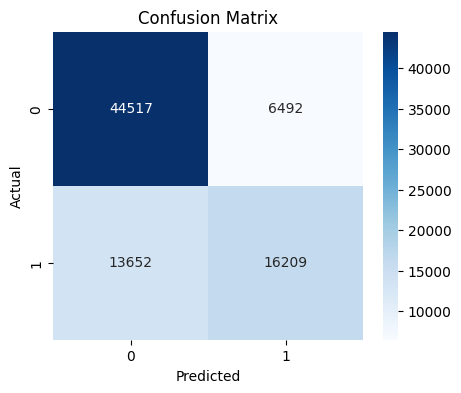


ROC-AUC Score: 0.8069


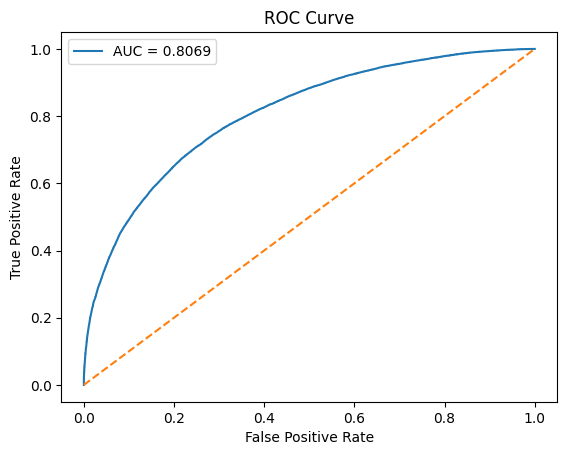

In [ ]:
#  Evaluate Logistic Regression model using the universal evaluation function
evaluate_model(lr_model, X_test_tfidf, y_test)


#### Training the Support Vector Machine (SVM) model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Combine question pairs into single text
X_train_text = [' '.join(pair) if isinstance(pair, list) else pair for pair in X_train] 
X_test_text  = [' '.join(pair) if isinstance(pair, list) else pair for pair in X_test]

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf  = vectorizer.transform(X_test_text)

# FAST Support Vector Machine
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

# Evaluate
y_pred = svm_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save model & vectorizer
model_path = root_dir + project_folder + 'models/svm_linear_model.pkl'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(svm_model, model_path)
joblib.dump(vectorizer, root_dir + project_folder + 'models/tfidf_vectorizer.pkl')
print("Linear SVM model saved!")

Accuracy: 0.7575244219117101
              precision    recall  f1-score   support

           0       0.79      0.84      0.81     51009
           1       0.70      0.61      0.65     29861

    accuracy                           0.76     80870
   macro avg       0.74      0.73      0.73     80870
weighted avg       0.75      0.76      0.75     80870

Linear SVM model saved!



MODEL PERFORMANCE
Accuracy : 0.7575
Precision: 0.6961
Recall   : 0.6093
F1-Score : 0.6498

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.79      0.84      0.81     51009
           1       0.70      0.61      0.65     29861

    accuracy                           0.76     80870
   macro avg       0.74      0.73      0.73     80870
weighted avg       0.75      0.76      0.75     80870



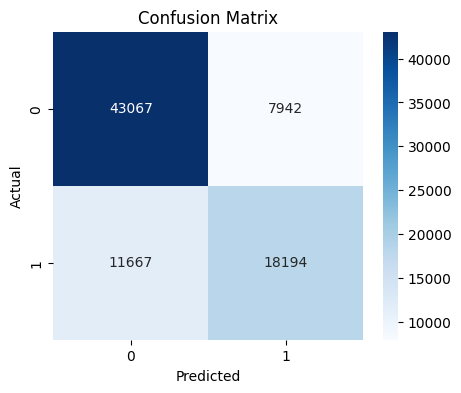


ROC-AUC Score: 0.8209


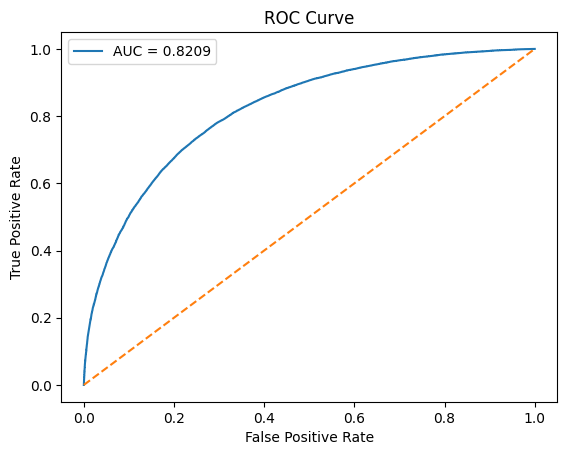

In [ ]:
# Evaluate SVM model using the universal evaluation function
evaluate_model(svm_model, X_test_tfidf, y_test)

#### Making the LSTM model pipeline

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report

# 1. Prepare text data
X_train_text = [' '.join(pair) if isinstance(pair, list) else pair for pair in X_train]
X_test_text  = [' '.join(pair) if isinstance(pair, list) else pair for pair in X_test]

# Tokenizer
max_words = 50000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len)


# 2. Build LSTM Model
model_lstm = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm.summary()


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##### Training the LSTM model for 5 epochs

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 4. Train the model
history = model_lstm.fit(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=512,
    validation_split=0.1,
    callbacks=[checkpoint]
)


y_pred_prob = model_lstm.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("LSTM model saved at:", model_path)

# 3. Save model
model_path = root_dir + project_folder + 'models/lstm_model.keras'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

Epoch 1/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7109 - loss: 0.5619
Epoch 1: val_accuracy improved from -inf to 0.75309, saving model to F:/sparktech/models/lstm_model.keras
569/569 ━━━━━━━━━━━━━━━━━━━━ 113s 196ms/step - accuracy: 0.7109 - loss: 0.5619 - val_accuracy: 0.7531 - val_loss: 0.5039
Epoch 2/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7777 - loss: 0.4616
Epoch 2: val_accuracy improved from 0.75309 to 0.76091, saving model to F:/sparktech/models/lstm_model.keras
569/569 ━━━━━━━━━━━━━━━━━━━━ 112s 197ms/step - accuracy: 0.7777 - loss: 0.4616 - val_accuracy: 0.7609 - val_loss: 0.4958
Epoch 3/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8113 - loss: 0.4005
Epoch 3: val_accuracy improved from 0.76091 to 0.76799, saving model to F:/sparktech/models/lstm_model.keras
569/569 ━━━━━━━━━━━━━━━━━━━━ 112s 198ms/step - accuracy: 0.8113 - loss: 0.4005 - val_accuracy: 0.7680 - val_loss: 0.4966
Epoch 4/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step

##### Training the LSTM model for 10 epochs

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 4. Train the model
history = model_lstm.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=512,
    validation_split=0.1,
    callbacks=[checkpoint]
)


y_pred_prob = model_lstm.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("LSTM model saved at:", model_path)

# 3. Save model
model_path = root_dir + project_folder + 'models/lstm_model.keras'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

Epoch 1/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9296 - loss: 0.1562
Epoch 1: val_accuracy improved from -inf to 0.77065, saving model to F:/sparktech/models/lstm_model.keras
569/569 ━━━━━━━━━━━━━━━━━━━━ 113s 198ms/step - accuracy: 0.9296 - loss: 0.1562 - val_accuracy: 0.7707 - val_loss: 0.9723
Epoch 2/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9358 - loss: 0.1413
Epoch 2: val_accuracy improved from 0.77065 to 0.77838, saving model to F:/sparktech/models/lstm_model.keras
569/569 ━━━━━━━━━━━━━━━━━━━━ 113s 198ms/step - accuracy: 0.9358 - loss: 0.1413 - val_accuracy: 0.7784 - val_loss: 1.0617
Epoch 3/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9395 - loss: 0.1338
Epoch 3: val_accuracy did not improve from 0.77838
569/569 ━━━━━━━━━━━━━━━━━━━━ 112s 198ms/step - accuracy: 0.9395 - loss: 0.1338 - val_accuracy: 0.7716 - val_loss: 1.1036
Epoch 4/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9445 - loss: 0.1230
Epoch 4: val_accura

2528/2528 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step

MODEL PERFORMANCE
Accuracy : 0.7698
Precision: 0.6741
Recall   : 0.7289
F1-Score : 0.7005

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     51009
           1       0.67      0.73      0.70     29861

    accuracy                           0.77     80870
   macro avg       0.75      0.76      0.76     80870
weighted avg       0.77      0.77      0.77     80870



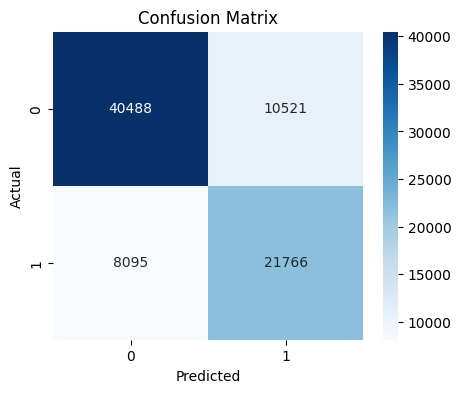


ROC-AUC Score: 0.8221


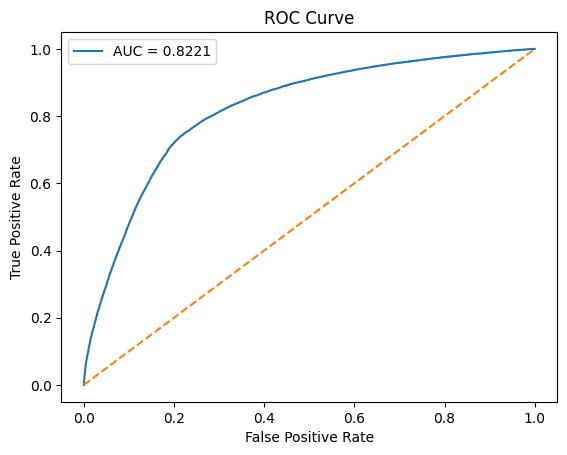

In [ ]:
# Evaluate LSTM model using the universal evaluation function
evaluate_model(model_lstm, X_test_pad, y_test)

In [ ]:
# New data split code which is compatible with all models deep learning, Siamese networks, sentence transformers, or dual encoders.

from sklearn.model_selection import train_test_split

# Assuming train_df is your full dataset with columns: 'question1', 'question2', 'is_duplicate'
X = train_df[['question1', 'question2']]
y = train_df['is_duplicate']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Checking the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (323477, 2)
X_test shape: (80870, 2)
y_train shape: (323477,)
y_test shape: (80870,)


In [ ]:
# Checking the contents
X_train['question1']
X_test['question2']

169012    I got terminated from Accenture, one month lat...
394679    What is the best photo slideshow screen saver ...
180716    What states have blue laws and what are those ...
284056    Get my child's direct messages on Instagram se...
194905    How do I send a push data to Firebase between ...
                                ...                        
69945                        How many of you hate to study?
242517                       How can I improve upon myself?
382034                  Is language necessary for thinking?
374074    How can I download all my videos saved as offl...
376515    Is 11th science the toughest class in a studen...
Name: question2, Length: 80870, dtype: object

In [ ]:
# Text Tokenization and Padding for Deep Learning Models
# This code tokenizes and pads the question pairs for input into deep learning models.
# It prepares the data for models like GRU by converting text to sequences of integers and ensuring uniform input length.

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Combine all questions for fitting tokenizer
all_questions = list(X_train['question1']) + list(X_train['question2'])

# Tokenizer
max_words = 50000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(all_questions)

# Convert questions to sequences
X_train_q1_seq = tokenizer.texts_to_sequences(X_train['question1'])
X_train_q2_seq = tokenizer.texts_to_sequences(X_train['question2'])
X_test_q1_seq  = tokenizer.texts_to_sequences(X_test['question1'])
X_test_q2_seq  = tokenizer.texts_to_sequences(X_test['question2'])

# Pad sequences
max_len = 50
X_train_q1_seq = pad_sequences(X_train_q1_seq, maxlen=max_len)
X_train_q2_seq = pad_sequences(X_train_q2_seq, maxlen=max_len)
X_test_q1_seq  = pad_sequences(X_test_q1_seq, maxlen=max_len)
X_test_q2_seq  = pad_sequences(X_test_q2_seq, maxlen=max_len)

print("Training q1 shape:", X_train_q1_seq.shape)
print("Training q2 shape:", X_train_q2_seq.shape)
print("Testing q1 shape:", X_test_q1_seq.shape)
print("Testing q2 shape:", X_test_q2_seq.shape)


Training q1 shape: (323477, 50)
Training q2 shape: (323477, 50)
Testing q1 shape: (80870, 50)
Testing q2 shape: (80870, 50)


#### Training the Siamese GRU model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report


# 1. Hyperparameters and constants of the Siamese GRU model
max_words = 50000   # vocab size
embedding_dim = 128
max_len = 50        # sequence length
gru_units = 64
dropout_rate = 0.3
batch_size = 512
epochs = 5


# 2. Input layers for question pairs, each representing a sequence of word indices
input_q1 = Input(shape=(max_len,), name='input_q1')
input_q2 = Input(shape=(max_len,), name='input_q2')

# 3. Shared embedding + GRU layers for encoding questions
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)
gru_layer = GRU(gru_units)

encoded_q1 = gru_layer(embedding_layer(input_q1))
encoded_q2 = gru_layer(embedding_layer(input_q2))

# 4. Merge with absolute difference (Manhattan distance)
def abs_diff(tensors):
    x1, x2 = tensors
    return K.abs(x1 - x2)

merged = Lambda(abs_diff)([encoded_q1, encoded_q2])
x = Dense(64, activation='relu')(merged)
x = Dropout(dropout_rate)(x)
output = Dense(1, activation='sigmoid')(x)

# 5. Building the GRU model
siamese_gru_model = Model(inputs=[input_q1, input_q2], outputs=output)
siamese_gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
siamese_gru_model.summary()

# 6. Saveing the model path
model_path = root_dir + project_folder + 'models/siamese_gru_model.keras'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_q1            │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_q2            │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 50, 128)   │  6,400,000 │ input_q1[0][0],   │
│ (Embedding)         │                   │            │ input_q2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 64)        │     37,248 │ embedding_6[0][0… │
│                     │                   │            │ embedding_6[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 64)        │          0 │ gru_2[0][0],      │
│                     │                   │            │ gru_2[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      4,160 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         65 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,441,473 (24.57 MB)

 Trainable params: 6,441,473 (24.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 7. Train the GRu model using the prepared sequences and the new data split
history = siamese_gru_model.fit(
    [X_train_q1_seq, X_train_q2_seq],
    y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpoint]
)

Epoch 1/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9516 - loss: 0.1312
Epoch 1: val_accuracy did not improve from 0.82713
569/569 ━━━━━━━━━━━━━━━━━━━━ 60s 105ms/step - accuracy: 0.9516 - loss: 0.1312 - val_accuracy: 0.8230 - val_loss: 0.5414
Epoch 2/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9595 - loss: 0.1106
Epoch 2: val_accuracy improved from 0.82713 to 0.82775, saving model to F:/sparktech/models/siamese_gru_model.keras
569/569 ━━━━━━━━━━━━━━━━━━━━ 60s 106ms/step - accuracy: 0.9595 - loss: 0.1106 - val_accuracy: 0.8277 - val_loss: 0.6098
Epoch 3/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9655 - loss: 0.0946
Epoch 3: val_accuracy did not improve from 0.82775
569/569 ━━━━━━━━━━━━━━━━━━━━ 60s 105ms/step - accuracy: 0.9655 - loss: 0.0946 - val_accuracy: 0.8264 - val_loss: 0.6459
Epoch 4/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9699 - loss: 0.0837
Epoch 4: val_accuracy improved from 0.82775 to 0.82787, saving model to F: